---
<a id='section1'></a>
## 1. Setting up environment

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

---
<a id='section2'></a>
## 2. Process and split data
Read data

In [2]:
covid = pd.read_csv("/kaggle/input/covid19-dataset/Covid Data.csv", low_memory = False)

Cleaning the data to keep only the rows containing 1, 2. values as 97 and 99 are essentialling missing data        

In [3]:
covid = covid.loc[(covid.CLASIFFICATION_FINAL < 4)]
covid = covid.loc[(covid.SEX == 1) | (covid.SEX == 2)]
covid = covid.loc[(covid.USMER == 1) | (covid.USMER == 2)]
covid = covid.loc[(covid.PATIENT_TYPE == 1) | (covid.PATIENT_TYPE == 2)]
covid = covid.loc[(covid.PNEUMONIA == 1) | (covid.PNEUMONIA == 2)]
covid = covid.loc[(covid.DIABETES == 1) | (covid.DIABETES == 2)]
covid = covid.loc[(covid.COPD == 1) | (covid.COPD == 2)]
covid = covid.loc[(covid.ASTHMA == 1) | (covid.ASTHMA == 2)]
covid = covid.loc[(covid.INMSUPR == 1) | (covid.INMSUPR == 2)]
covid = covid.loc[(covid.HIPERTENSION == 1) | (covid.HIPERTENSION == 2)]
covid = covid.loc[(covid.OTHER_DISEASE == 1) | (covid.OTHER_DISEASE == 2)]
covid = covid.loc[(covid.CARDIOVASCULAR == 1) | (covid.CARDIOVASCULAR == 2)]
covid = covid.loc[(covid.OBESITY == 1) | (covid.OBESITY == 2)]
covid = covid.loc[(covid.RENAL_CHRONIC == 1) | (covid.RENAL_CHRONIC == 2)]
covid = covid.loc[(covid.TOBACCO == 1) | (covid.TOBACCO == 2)]

Modifying data to get it converted to One Hot Encoded data

In [4]:
covid.SEX = covid.SEX.apply(lambda x: x if x == 1 else 0)  
covid.USMER = covid.USMER.apply(lambda x: x if x == 1 else 0)                     # no = 0, yes = 1
covid.PATIENT_TYPE = covid.PATIENT_TYPE.apply(lambda x: 0 if x == 1 else 1)     
covid.PNEUMONIA = covid.PNEUMONIA.apply(lambda x: x if x == 1 else 0)           
covid.DIABETES = covid.DIABETES.apply(lambda x: x if x == 1 else 0)             
covid.COPD = covid.COPD.apply(lambda x: x if x == 1 else 0)                     
covid.ASTHMA = covid.ASTHMA.apply(lambda x: x if x == 1 else 0)                 
covid.INMSUPR = covid.INMSUPR.apply(lambda x: x if x == 1 else 0)               
covid.HIPERTENSION = covid.HIPERTENSION.apply(lambda x: x if x == 1 else 0)     
covid.OTHER_DISEASE = covid.OTHER_DISEASE.apply(lambda x: x if x == 1 else -0)  
covid.CARDIOVASCULAR = covid.CARDIOVASCULAR.apply(lambda x: x if x == 1 else 0) 
covid.OBESITY = covid.OBESITY.apply(lambda x: x if x == 1 else 0)               
covid.RENAL_CHRONIC = covid.RENAL_CHRONIC.apply(lambda x: x if x == 1 else 0)   
covid.TOBACCO = covid.TOBACCO.apply(lambda x: x if x == 1 else 0)               
covid.DATE_DIED = covid.DATE_DIED.apply(lambda x: 0 if x == "9999-99-99" else 1)
covid.PREGNANT = covid.PREGNANT.apply(lambda x: x if x == 1 else 0)           
covid.INTUBED = covid.INTUBED.apply(lambda x: x if x == 1 else 0)                   
covid.ICU = covid.ICU.apply(lambda x: x if x == 1 else 0)

Creating the label column from summing three columns of the data. This column represents whether the patient is at risk from covid.

In [5]:
covid['AT_RISK'] = covid['DATE_DIED'] + covid['INTUBED'] + covid['ICU']
covid.AT_RISK = covid.AT_RISK.apply(lambda x: 1 if x > 0 else 0) 

# Drop a few columns which are intuitively not longer useful
covid.drop(columns = ['CLASIFFICATION_FINAL', 'INTUBED', 'ICU', 'DATE_DIED'], inplace=True)

In [6]:
print(covid.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388878 entries, 0 to 1047937
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   USMER           388878 non-null  int64
 1   MEDICAL_UNIT    388878 non-null  int64
 2   SEX             388878 non-null  int64
 3   PATIENT_TYPE    388878 non-null  int64
 4   PNEUMONIA       388878 non-null  int64
 5   AGE             388878 non-null  int64
 6   PREGNANT        388878 non-null  int64
 7   DIABETES        388878 non-null  int64
 8   COPD            388878 non-null  int64
 9   ASTHMA          388878 non-null  int64
 10  INMSUPR         388878 non-null  int64
 11  HIPERTENSION    388878 non-null  int64
 12  OTHER_DISEASE   388878 non-null  int64
 13  CARDIOVASCULAR  388878 non-null  int64
 14  OBESITY         388878 non-null  int64
 15  RENAL_CHRONIC   388878 non-null  int64
 16  TOBACCO         388878 non-null  int64
 17  AT_RISK         388878 non-null  int64
dtypes: 

split the data to train(90%), validation(5%) and test(5%)

In [7]:
train, validation = train_test_split(covid, test_size=0.1, shuffle=True)
validation, test = train_test_split(validation, test_size=0.5, shuffle=True)

validation_y = validation.AT_RISK.to_numpy()
validation_x = validation.drop(columns = ['AT_RISK']).to_numpy()

test_y = test.AT_RISK.to_numpy()
test_x = test.drop(columns = ['AT_RISK']).to_numpy()

### Calculate results
function that returns F-measure (F1-score) for given data and labels

In [8]:
def get_Fmeasure(prediction, labels):

  # Compares the prediction of each object to its label
  true_positive = np.sum((prediction + labels) == 2)
  false_positive = np.sum((labels - prediction) == -1)
  false_negative = np.sum((prediction - labels) == -1)
  positive = np.count_nonzero(labels == 1)
  negative = len(labels)-positive

  # Calculate F-measure
  accuracy = 100*np.sum(prediction == labels)/len(labels)
  recall = true_positive / (true_positive + false_negative)
  precision = true_positive / (true_positive + false_positive)
  eval = 2*(precision * recall) / (precision + recall)
  return eval

---
<a id='section3'></a>
## 3. K-Nearest Neighbors
The K-Nearest Neighbours is non-linear classifier in which an object is classified to the class most common among its k nearest neighbours in the train set. The hyperparameters for the KNN algorithm are the value of k and the distance function that calculates the distance between two objects. 

Build KNN model

In [9]:
class KNearestNeighbor(object):
    """ a kNN classifier with several distance function"""

    def __init__(self):
        pass

    def train(self, X, y):

        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, dist_func="l2"):
        self.k = k
        self.dist_f = dist_func

        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))

        # calculate the distance matrix according to the distance function
        if dist_func == "l2":
            dists = scipy.spatial.distance_matrix(X, self.X_train)
        elif dist_func == "l1":
            dists = scipy.spatial.distance_matrix(X, self.X_train, p=1)
        elif dist_func == "linf":
            dists = scipy.spatial.distance_matrix(X, self.X_train, p=np.inf)
        else:
            raise ValueError('Invalid value %d for dist_func' % dist_func)
        
        # calculate prediction on X
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            k_nearest_idxs = np.argsort(dists[i, :])[:k]
            closest_y = self.y_train[k_nearest_idxs]
            y_pred[i] = np.argmax(np.bincount(closest_y))
        return y_pred

    def getK(self):
        return self.k

    def get_func(self):
        return self.dist_f

Undersampling the train set

In [10]:
atrisk = train[train.AT_RISK==1][:2000]
nonrisk = train[train.AT_RISK==0][:2000]
part_train = pd.concat([nonrisk, atrisk])
train_y = part_train.AT_RISK.to_numpy()
train_x = part_train.drop(columns = ['AT_RISK']).to_numpy()

set optional knn hyperparameters

In [11]:
k_choices = [1, 5, 13, 23, 31]
dist_func = ["l1", "l2", "linf"]
knn_fmeasures = {}
knn_best_result = 0

for k in k_choices:
    knn_fmeasures[k] = np.zeros(len(dist_func))
    for (i, func) in enumerate(dist_func):
        # create a kNN classifier instance and compute the prediction
        knn_classifier = KNearestNeighbor()
        knn_classifier.train(train_x, train_y)
        pred_y = knn_classifier.predict(validation_x, k=k, dist_func=func) 

        # calculate F-measures and save best model
        knn_fmeasures[k][i] = get_Fmeasure(pred_y, validation_y)
        if knn_fmeasures[k][i] > knn_best_result:
            knn_best_result = knn_fmeasures[k][i]
            knn_best_model = knn_classifier

plot the results

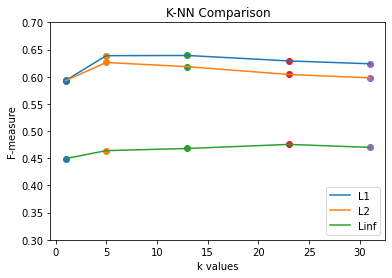

In [12]:
l1, l2, linf = [], [], []
for k in k_choices:
    fmeasures = knn_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(knn_fmeasures[k][0])
    l2.append(knn_fmeasures[k][1])
    linf.append(knn_fmeasures[k][2])

# create line between all k values for each distance function
plt.errorbar(k_choices, l1, label ='L1')
plt.errorbar(k_choices, l2, label ='L2')
plt.errorbar(k_choices, linf, label ='Linf')
plt.legend(loc ='lower right')

plt.title('K-NN Comparison')
plt.xlabel('k values')
plt.ylabel('F-measure')
plt.ylim(0.3, 0.7)
plt.show()

print best model parameters

In [13]:
print('best result for: k = %d, distance function = %s, F-measure = %f' % (knn_best_model.getK(), knn_best_model.get_func(), knn_best_result))

best result for: k = 13, distance function = l1, F-measure = 0.639079


---
<a id='section4'></a>
## 4. SVM
SVM is a classifier that separates data points using a linear hyperplane with the largest amount of margin between the two classes in the train set. SVM can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping the inputs into high-dimensional feature spaces.

split the data to x and y

In [14]:
part_train, _ = train_test_split(train, test_size=0.9, shuffle=True)
train_y = part_train.AT_RISK.to_numpy()
train_x = part_train.drop(columns = ['AT_RISK']).to_numpy()

set all SVM kernel options

In [15]:
kernels = ["linear", "poly", "rbf"]
svm_fmeasures = {}
svm_best_result = 0

for kernel in kernels:
    # create a SVM classifier instance and compute the prediction
    svm_classifier = SVC(kernel=kernel, degree=8, class_weight='balanced')
    svm_classifier.fit(train_x, train_y)
    y_pred = svm_classifier.predict(validation_x)

    # calculate F-measures and save best model
    svm_fmeasures[kernel] = get_Fmeasure(y_pred, validation_y)
    if svm_fmeasures[kernel] > svm_best_result:
        svm_best_result = svm_fmeasures[kernel]
        svm_best_model = svm_classifier

plot all the results

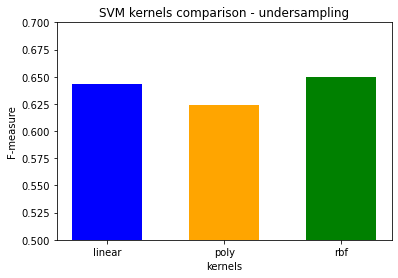

In [16]:
plt.bar(svm_fmeasures.keys(), svm_fmeasures.values(), color=['blue', 'orange', 'green', 'red'], width=.6)
plt.title('SVM kernels comparison - undersampling')
plt.xlabel('kernels')
plt.ylabel('F-measure')
plt.ylim(0.5, 0.7)
plt.show()

print best model parameters

In [17]:
print('best result for: kernel = %s, F-measure = %f' % (svm_best_model.get_params()['kernel'], svm_best_result))

best result for: kernel = rbf, F-measure = 0.649600


---
<a id='section5'></a>
## 5. Decision Tree
A decision tree is a flowchart-like structure in which each internal node represents a "test" on a feature, each branch represents the outcome of the test, and each leaf node represents a class label. The paths from root to leaf represent classification rules. The decision tree algorithm uses heuristic functions for selecting the splitting criterion that partition data into the best possible manner.

undersampling the train set

In [18]:
train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()

set Decision Tree parameters

In [19]:
heuristics = ["entropy", "gini"]
splitters = ["best", "random"]
max_depth = [5, 7, 11, 13, 17]
dt_fmeasures = {}
dt_best_result = 0

for d in max_depth:
    dt_fmeasures[d] = np.zeros(len(heuristics)*len(splitters))
    i=0
    for heuristic, splitter in [(heuristic, splitter) for heuristic in heuristics for splitter in splitters]:
        # create a Decision Tree classifier instance and compute the prediction
        dt_classifier = DecisionTreeClassifier(criterion=heuristic, splitter=splitter, max_depth=d, class_weight='balanced')
        dt_classifier.fit(train_x, train_y)
        y_pred = dt_classifier.predict(validation_x)

        # calculate F-measures and save best model
        dt_fmeasures[d][i] = get_Fmeasure(y_pred, validation_y)
        if dt_fmeasures[d][i] > dt_best_result:
            dt_best_result = dt_fmeasures[d][i]
            dt_best_model = dt_classifier
        i=i+1

plot the results

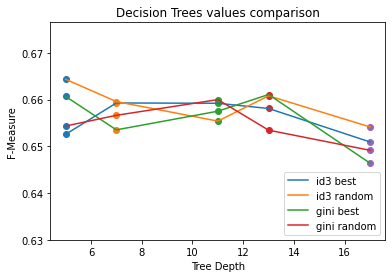

In [20]:
l1, l2, l3, l4 = [], [], [], []
for k in dt_fmeasures.keys():
    fmeasures = dt_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(dt_fmeasures[k][0])
    l2.append(dt_fmeasures[k][1])
    l3.append(dt_fmeasures[k][2])
    l4.append(dt_fmeasures[k][3])

# create line for each of the four models
plt.errorbar(max_depth, l1, label ='id3 best')
plt.errorbar(max_depth, l2, label ='id3 random')
plt.errorbar(max_depth, l3, label ='gini best')
plt.errorbar(max_depth, l4, label ='gini random')
plt.legend(loc ='lower right')
plt.title('Decision Trees values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.ylim(0.630, 0.6765)
plt.show()

print best model parameters

In [21]:
params = dt_best_model.get_params()
print('best result for: heuristic = %s, splitter = %s, max depth = %d, F-measure = %f' % (params['criterion'], params['splitter'], params['max_depth'], dt_best_result))

best result for: heuristic = entropy, splitter = random, max depth = 5, F-measure = 0.664323


---
<a id='section6'></a>
## 6. Random Forest
Random forests constructs multitude decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. Random forests generally outperform decision trees

undersampling the train set

In [22]:
train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()

set Random Forest parameters

In [23]:
heuristics = ["entropy", "gini"]
max_depth = [5, 11, 13, 17]
rf_fmeasures = {}
rf_best_result = 0
for d in max_depth:
    rf_fmeasures[d] = np.zeros(len(heuristics))
    for (i, heuristic) in enumerate(heuristics):
        # create a Random Forest classifier instance and compute the prediction
        rf_classifier = RandomForestClassifier(n_estimators=100, 
                                               criterion=heuristic, 
                                               max_depth=d,  
                                               class_weight='balanced')
        rf_classifier.fit(train_x, train_y)
        y_pred = rf_classifier.predict(validation_x)

        # calculate F-measures and save best model
        rf_fmeasures[d][i] = get_Fmeasure(y_pred, validation_y)
        if rf_fmeasures[d][i] > rf_best_result:
            rf_best_result = rf_fmeasures[d][i]
            rf_best_model = rf_classifier   

plot the results

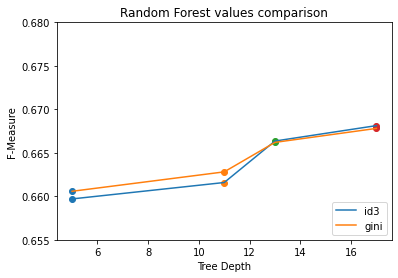

In [24]:
l1, l2 = [], []
for k in rf_fmeasures.keys():
    fmeasures = rf_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(rf_fmeasures[k][0])
    l2.append(rf_fmeasures[k][1])

# create line for each  models
plt.errorbar(max_depth, l1, label ='id3')
plt.errorbar(max_depth, l2, label ='gini')
plt.legend(loc ='lower right')
plt.title('Random Forest values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.ylim(0.655, 0.68)
plt.show()

print best model parameters

In [25]:
params = rf_best_model.get_params()
print('best result for: heuristic = %s, max depth = %d, F-measure = %f' % (params['criterion'], params['max_depth'], rf_best_result))

best result for: heuristic = entropy, max depth = 17, F-measure = 0.668128


---
<a id='section7'></a>
## 7. Multilayer Perceptron
An MLP model consists of at least three layers of nodes: an input layer, a hidden layer, and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training.

undersampling the train set

In [26]:
atrisk = train[train.AT_RISK==1][:20000]
nonrisk = train[train.AT_RISK==0][:20000]
part_train = (pd.concat([nonrisk, atrisk])).sample(frac = 1)
train_y = part_train.AT_RISK.to_numpy()
train_x = part_train.drop(columns = ['AT_RISK']).to_numpy()

set MLP parameters

In [27]:
layers = [(100,50,30,10,5), (15,10,5,10,15), (20,20,20,20), (10)]
optimizers = ['adam', 'sgd']
mlp_fmeasures = {}
mlp_best_result = 0

for (i, opt) in  enumerate(optimizers):
    mlp_fmeasures[i] = np.zeros(len(layers))
    for (j, layer) in enumerate(layers):
        # create a Logistic Regression classifier instance and compute the prediction
        mlp_classifier = MLPClassifier(hidden_layer_sizes = layer,
                                          solver = opt,
                                          learning_rate ='adaptive',
                                          max_iter = 500)
        mlp_classifier.fit(train_x, train_y)
        y_pred = mlp_classifier.predict(validation_x)

        # calculate F-measures and save best model
        mlp_fmeasures[i][j] = get_Fmeasure(y_pred, validation_y)
        if mlp_fmeasures[i][j] > mlp_best_result:
            mlp_best_result = mlp_fmeasures[i][j]
            mlp_best_model = mlp_classifier

plot the results

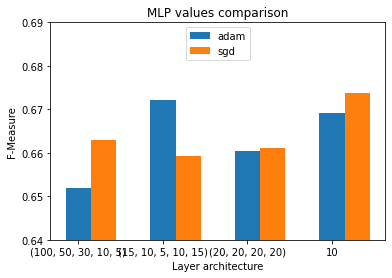

In [28]:
width = 0
for i in mlp_fmeasures.keys():
    fmeasures = mlp_fmeasures[i]
    plt.bar(np.arange(len(fmeasures))+width, fmeasures, width=0.3, label=optimizers[i])
    width += 0.3

plt.xticks(range(len(layers)), layers)
plt.legend(loc ='upper center')
plt.title('MLP values comparison')
plt.xlabel('Layer architecture')
plt.ylabel('F-Measure')
plt.ylim(0.64, 0.69)
plt.show()

print best model parameters

In [29]:
params = mlp_best_model.get_params()
print('best result for: optimizer = %s, layer = %s, F-measure = %f' % (params['solver'], params['hidden_layer_sizes'], mlp_best_result))

best result for: optimizer = sgd, layer = 10, F-measure = 0.673659


---
<a id='section8'></a>
## 8. Final Evaluation
runnig the best models from each technique on the test set.

In [30]:
knn_pred = knn_best_model.predict(test_x)
svm_pred = svm_best_model.predict(test_x)
dt_pred = dt_best_model.predict(test_x)
rf_pred = rf_best_model.predict(test_x)
mlp_pred = mlp_best_model.predict(test_x)

get results

In [31]:
final_fmeasures = {}
final_fmeasures['knn'] = get_Fmeasure(knn_pred, test_y)
final_fmeasures['svm'] = get_Fmeasure(svm_pred, test_y)
final_fmeasures['decision tree'] = get_Fmeasure(dt_pred, test_y)
final_fmeasures['rand forest'] = get_Fmeasure(rf_pred, test_y)
final_fmeasures['mlp'] = get_Fmeasure(mlp_pred, test_y)

plot all the results

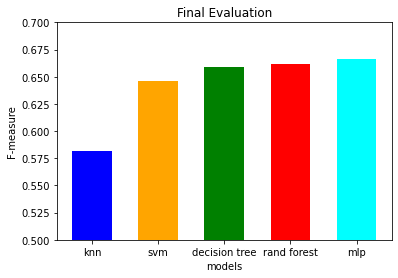

In [32]:
plt.bar(final_fmeasures.keys(), final_fmeasures.values(), color=['blue', 'orange', 'green', 'red', 'cyan'], width=.6)
plt.title('Final Evaluation')
plt.xlabel('models')
plt.ylabel('F-measure')
plt.ylim(0.5, 0.7)
plt.show()

print best model results

In [33]:
print('\n', classification_report(test_y, rf_pred))


               precision    recall  f1-score   support

           0       0.98      0.85      0.91     16487
           1       0.52      0.90      0.66      2957

    accuracy                           0.86     19444
   macro avg       0.75      0.88      0.79     19444
weighted avg       0.91      0.86      0.87     19444

